# introduction

we want to be able to align waveforms with a time and phase shift so that they agree within some time or frequency window

In [136]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

In [137]:
import numpy as np

In [138]:
import lalsimulation as lalsim

In [139]:
import utils

In [140]:
wf1=utils.WaveformGeneration(approximant=lalsim.SEOBNRv4, f_min=20, t_min=-2000, t_max=100, npts=10000, nrfile=None, q=4)
wf2=utils.WaveformGeneration(approximant=lalsim.TaylorT1, f_min=20, t_min=-2000, t_max=100, npts=10000, nrfile=None, q=4)

In [141]:
# wf1.times=wf1.times-wf1.times[0]
# wf2.times=wf2.times-wf2.times[0]

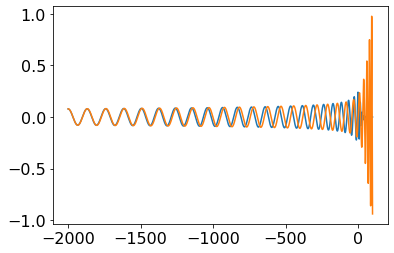

In [142]:
plt.plot(wf1.times, wf1.h22.real)
plt.plot(wf2.times, wf2.h22.real)
# plt.xlim(-100, 100)

In [143]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import scipy.integrate
import scipy.optimize

from functools import partial

# def dephasing(iphi1, iphi2, win1, win2, z):
#     dt, dphi = z
#     return quad(lambda t: np.abs((iphi1(t)-iphi2(t+dt)+dphi)),win1,win2)[0]


def dephasing(iphi1, iphi2, win1, win2, z):
    """
    ty TD
    """
    dt, dphi = z

    t1 = lambda t: iphi1(t)
    t2 = lambda t, dt, dphi: iphi2(t+dt)+dphi

    integrand = lambda t: np.abs(t1(t)-t2(t, dt, dphi)) 

    return scipy.integrate.quad(integrand, win1, win2)[0]


In [144]:
iphi1 = IUS(wf1.times, wf1.phase)
iphi2 = IUS(wf2.times, wf2.phase)

In [145]:
# win1=0
# win2=1000

win1=wf1.times[0]
win2=win1+1500
# win2=wf1.times[-1]

In [146]:
partial_dephasing = partial(dephasing, iphi1, iphi2, win1, win2)

In [147]:
sol=scipy.optimize.minimize(partial_dephasing, [0, 0], tol=1e-12)

/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_17406/2542064810.py:21: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(integrand, win1, win2)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_17406/2542064810.py:21: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably ga

In [148]:
sol.x

array([58.77772078,  2.77668852])

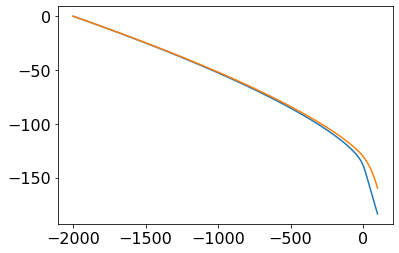

In [149]:
plt.figure()
plt.plot(wf1.times, wf1.phase)
plt.plot(wf2.times, wf2.phase)

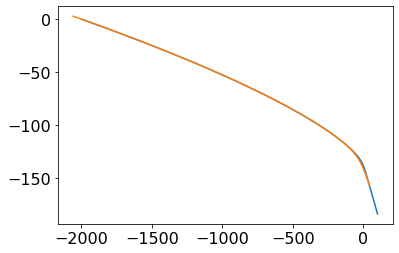

In [150]:
plt.figure()
plt.plot(wf1.times, wf1.phase)
plt.plot(wf2.times-sol.x[0], wf2.phase+sol.x[1])

In [151]:
iphi2_shift = IUS(wf2.times-sol.x[0], wf2.phase+sol.x[1])

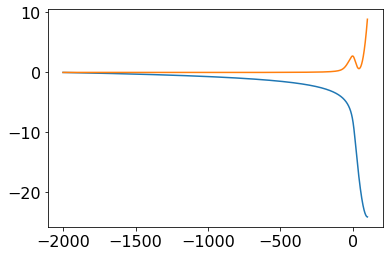

In [152]:
plt.figure()
plt.plot(wf1.times, wf1.phase-wf2.phase)
plt.plot(wf1.times, wf1.phase-(iphi2_shift(wf1.times)))

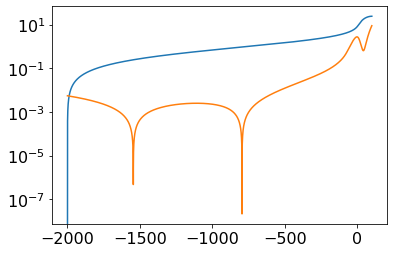

In [153]:
plt.figure()
plt.plot(wf1.times, np.abs(wf1.phase-wf2.phase))
plt.plot(wf1.times, np.abs(wf1.phase-(iphi2_shift(wf1.times))))
plt.yscale('log')

(-500.0, 100.0)

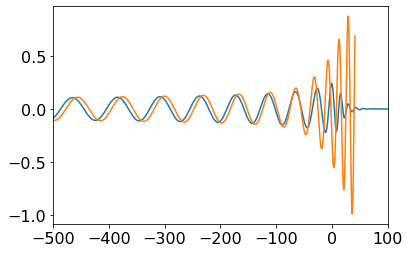

In [154]:
plt.figure()
plt.plot(wf1.times, wf1.h22.real)
# plt.plot(wf2.times, wf2.h22.real)

plt.plot(wf2.times-sol.x[0], np.real(wf2.amp * np.exp(-1.j * (wf2.phase-sol.x[1]))))

plt.xlim(-500, 100)

# plt.xlim(-10000-5000, -9000-5000)

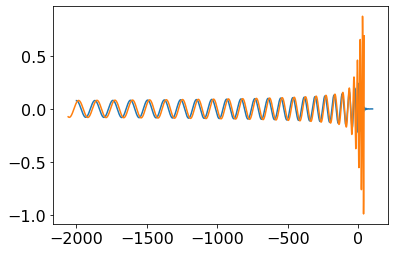

In [155]:
plt.figure()
plt.plot(wf1.times, wf1.h22.real)
# plt.plot(wf2.times, wf2.h22.real)

plt.plot(wf2.times-sol.x[0], np.real(wf2.amp * np.exp(-1.j * (wf2.phase-sol.x[1]))))

# plt.xlim(-500, 100)

# plt.xlim(-10000-5000, -9000-5000)

In [156]:
ifreq2_shift = IUS(wf2.times-sol.x[0], wf2.freq)

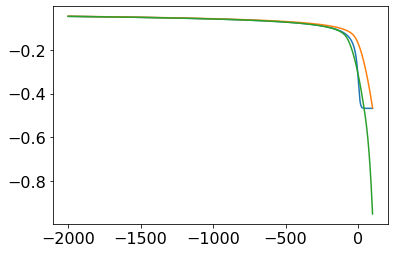

In [157]:
plt.figure()
plt.plot(wf1.times, wf1.freq)
plt.plot(wf2.times, wf2.freq)
# plt.plot(wf2.times-sol.x[0], wf2.freq)
plt.plot(wf1.times, ifreq2_shift(wf1.times))

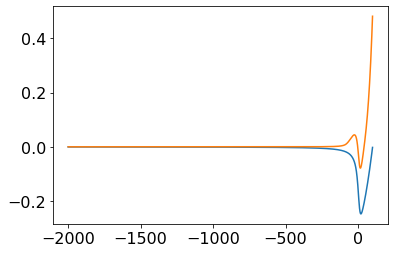

In [158]:
plt.figure()
plt.plot(wf1.times, wf1.freq-wf2.freq)
plt.plot(wf1.times, wf1.freq-ifreq2_shift(wf1.times))

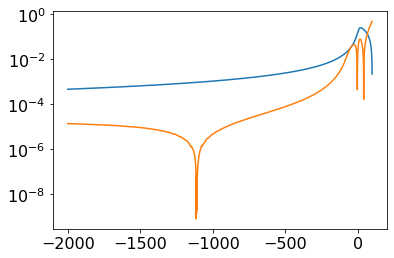

In [159]:
plt.figure()
plt.plot(wf1.times, np.abs(wf1.freq-wf2.freq))
plt.plot(wf1.times, np.abs(wf1.freq-ifreq2_shift(wf1.times)))
plt.yscale('log')

# function

What I want is to be able to align a list of waveforms subject to some conditions

1. the peak amplitude is at t=0
2. the phase of the 22 mode is 0 at t=t_start
3. for waveforms with the same physical parameters they are optimally aligned with some reference case